# পিটার এবং নেকড়ে: রিইনফোর্সমেন্ট লার্নিং প্রাইমার

এই টিউটোরিয়ালে, আমরা পথ খোঁজার সমস্যায় রিইনফোর্সমেন্ট লার্নিং প্রয়োগ করতে শিখব। এই সেটিংটি রাশিয়ান সুরকার [সের্গেই প্রোকোফিয়েভ](https://en.wikipedia.org/wiki/Sergei_Prokofiev) এর [পিটার এবং নেকড়ে](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) সঙ্গীতধর্মী রূপকথা দ্বারা অনুপ্রাণিত। এটি একটি গল্প যেখানে তরুণ পথিক পিটার সাহসের সাথে তার বাড়ি থেকে বেরিয়ে বনের ফাঁকা জায়গায় নেকড়েকে তাড়ানোর জন্য যায়। আমরা এমন মেশিন লার্নিং অ্যালগরিদম প্রশিক্ষণ দেব যা পিটারকে আশেপাশের এলাকা অন্বেষণ করতে এবং একটি সর্বোত্তম নেভিগেশন মানচিত্র তৈরি করতে সাহায্য করবে।

প্রথমে, চলুন কিছু দরকারী লাইব্রেরি ইমপোর্ট করি:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## রিইনফোর্সমেন্ট লার্নিং-এর ওভারভিউ

**রিইনফোর্সমেন্ট লার্নিং** (RL) একটি শেখার পদ্ধতি যা আমাদেরকে একটি **এজেন্ট**-এর **পরিবেশ**-এ **অনুকূল আচরণ** শেখার সুযোগ দেয়, যেখানে আমরা অনেক পরীক্ষা-নিরীক্ষা চালাই। এই পরিবেশে একটি এজেন্টের অবশ্যই একটি **লক্ষ্য** থাকতে হবে, যা একটি **রিওয়ার্ড ফাংশন** দ্বারা সংজ্ঞায়িত।

## পরিবেশ

সহজতার জন্য, চলুন পিটারের জগৎকে `width` x `height` আকারের একটি বর্গাকার বোর্ড হিসেবে কল্পনা করি। এই বোর্ডের প্রতিটি সেল হতে পারে:
* **মাটি**, যেখানে পিটার এবং অন্যান্য প্রাণীরা হাঁটতে পারে
* **পানি**, যেখানে আপনি স্পষ্টতই হাঁটতে পারবেন না
* **গাছ** বা **ঘাস** - এমন একটি জায়গা যেখানে আপনি কিছুক্ষণ বিশ্রাম নিতে পারেন
* **আপেল**, যা এমন কিছু যা পিটার খুঁজে পেলে খুশি হবে এবং নিজেকে খাওয়াতে পারবে
* **নেকড়ে**, যা বিপজ্জনক এবং এড়িয়ে চলা উচিত

পরিবেশের সাথে কাজ করার জন্য, আমরা `Board` নামে একটি ক্লাস সংজ্ঞায়িত করব। এই নোটবুকটি খুব বেশি জটিল না করার জন্য, বোর্ডের সাথে কাজ করার সমস্ত কোড আমরা একটি আলাদা `rlboard` মডিউলে সরিয়ে রেখেছি, যা আমরা এখন ইমপোর্ট করব। আপনি এই মডিউলের ভিতরে তাকিয়ে বাস্তবায়নের অভ্যন্তরীণ বিষয়গুলি সম্পর্কে আরও বিশদ জানতে পারেন।


In [2]:
from rlboard import *

এখন চলুন একটি র্যান্ডম বোর্ড তৈরি করি এবং দেখি এটি কেমন দেখায়:


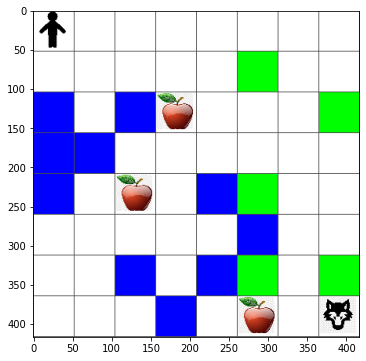

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## কার্যক্রম এবং নীতি

আমাদের উদাহরণে, পিটারের লক্ষ্য হবে একটি আপেল খুঁজে বের করা, একইসাথে নেকড়ে এবং অন্যান্য বাধা এড়িয়ে চলা। এটি করতে, সে মূলত হাঁটতে পারে যতক্ষণ না সে একটি আপেল খুঁজে পায়। তাই, যেকোনো অবস্থানে সে নিচের চারটি কার্যক্রমের মধ্যে একটি বেছে নিতে পারে: উপরে, নিচে, বামে এবং ডানে। আমরা এই কার্যক্রমগুলোকে একটি ডিকশনারি হিসেবে সংজ্ঞায়িত করব এবং সেগুলোকে সংশ্লিষ্ট কোঅর্ডিনেট পরিবর্তনের জোড়ার সাথে মানচিত্রে সংযুক্ত করব। উদাহরণস্বরূপ, ডানে (`R`) চলা একটি জোড়া `(1,0)` এর সাথে সম্পর্কিত হবে।


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

আমাদের এজেন্ট (পিটার)-এর কৌশল একটি তথাকথিত **নীতি** দ্বারা সংজ্ঞায়িত হয়। চলুন সবচেয়ে সহজ নীতি, যাকে **র্যান্ডম ওয়াক** বলা হয়, তা বিবেচনা করি।

## র্যান্ডম ওয়াক

প্রথমে চলুন একটি র্যান্ডম ওয়াক কৌশল বাস্তবায়ন করে আমাদের সমস্যার সমাধান করি।


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

চলুন র‍্যান্ডম ওয়াক পরীক্ষা কয়েকবার চালাই এবং গড়ে কতগুলো ধাপ নেওয়া হয়েছে তা দেখি:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## পুরস্কার ফাংশন

আমাদের নীতিকে আরও বুদ্ধিমান করতে, আমাদের বুঝতে হবে কোন পদক্ষেপগুলি অন্যগুলোর তুলনায় "ভালো"।


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## কিউ-লার্নিং

একটি কিউ-টেবিল বা বহু-মাত্রিক অ্যারে তৈরি করুন। যেহেতু আমাদের বোর্ডের মাত্রা `width` x `height`, আমরা কিউ-টেবিলকে একটি numpy অ্যারে দিয়ে উপস্থাপন করতে পারি যার আকৃতি হবে `width` x `height` x `len(actions)`।


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Q-টেবিলটি বোর্ডে টেবিলটি চিত্রিত করার জন্য প্লট ফাংশনে পাস করুন:


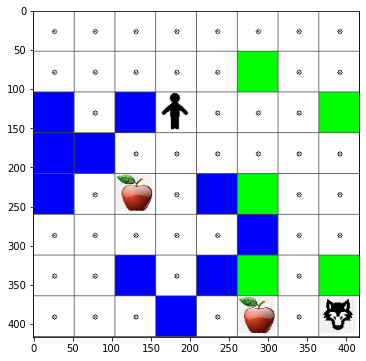

In [9]:
m.plot(Q)

## কিউ-লার্নিং এর মূল বিষয়: বেলম্যান সমীকরণ এবং শেখার অ্যালগরিদম

আমাদের শেখার অ্যালগরিদমের জন্য একটি ছদ্ম-কোড লিখুন:

* সমস্ত অবস্থান এবং ক্রিয়ার জন্য সমান সংখ্যায় Q-টেবিল Q আরম্ভ করুন
* শেখার হার সেট করুন $\alpha\leftarrow 1$
* বহুবার সিমুলেশন পুনরাবৃত্তি করুন
   1. যেকোনো র্যান্ডম অবস্থান থেকে শুরু করুন
   1. পুনরাবৃত্তি করুন
        1. অবস্থান $s$ এ একটি ক্রিয়া $a$ নির্বাচন করুন
        2. ক্রিয়া সম্পাদন করে নতুন অবস্থান $s'$ এ যান
        3. যদি আমরা খেলার শেষ অবস্থার সম্মুখীন হই, অথবা মোট পুরস্কার খুব কম হয় - সিমুলেশন থেকে বেরিয়ে আসুন  
        4. নতুন অবস্থানে পুরস্কার $r$ গণনা করুন
        5. বেলম্যান সমীকরণ অনুযায়ী Q-ফাংশন আপডেট করুন: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. মোট পুরস্কার আপডেট করুন এবং $\alpha$ কমান।

## শোষণ বনাম অনুসন্ধান

সেরা পদ্ধতি হলো শোষণ এবং অনুসন্ধানের মধ্যে ভারসাম্য বজায় রাখা। যখন আমরা আমাদের পরিবেশ সম্পর্কে আরও শিখি, তখন আমরা আরও বেশি সম্ভাবনা নিয়ে সর্বোত্তম পথ অনুসরণ করব, তবে মাঝে মাঝে অনাবিষ্কৃত পথ বেছে নেওয়া উচিত।

## পাইথন বাস্তবায়ন

এখন আমরা শেখার অ্যালগরিদম বাস্তবায়ন করতে প্রস্তুত। তার আগে, আমাদের এমন একটি ফাংশন প্রয়োজন যা Q-টেবিলের যেকোনো সংখ্যা সংশ্লিষ্ট ক্রিয়ার জন্য সম্ভাবনার ভেক্টরে রূপান্তর করবে:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

আমরা মূল ভেক্টরে একটি ছোট পরিমাণ `eps` যোগ করি যাতে প্রাথমিক ক্ষেত্রে, যখন ভেক্টরের সমস্ত উপাদান অভিন্ন হয়, তখন 0 দিয়ে ভাগ করার সমস্যা এড়ানো যায়।

আমরা যে প্রকৃত শিক্ষণ অ্যালগরিদমটি চালাব তা ৫০০০টি পরীক্ষার জন্য, যাকে **epochs** ও বলা হয়:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

এই অ্যালগরিদমটি কার্যকর করার পরে, Q-টেবিলটি এমন মানগুলির সাথে আপডেট হওয়া উচিত যা প্রতিটি ধাপে বিভিন্ন ক্রিয়ার আকর্ষণীয়তা সংজ্ঞায়িত করে। এখানে টেবিলটি চিত্রিত করুন:


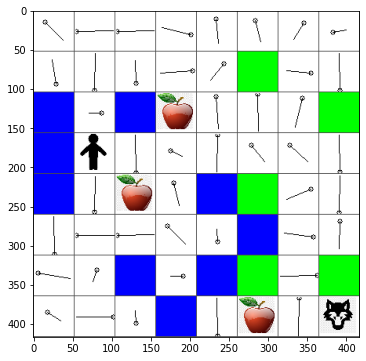

In [12]:
m.plot(Q)

## নীতিমালা পরীক্ষা করা

যেহেতু Q-Table প্রতিটি অবস্থায় প্রতিটি ক্রিয়ার "আকর্ষণীয়তা" তালিকাভুক্ত করে, এটি আমাদের জগতে কার্যকর নেভিগেশন সংজ্ঞায়িত করতে ব্যবহার করা বেশ সহজ। সবচেয়ে সহজ ক্ষেত্রে, আমরা কেবল সেই ক্রিয়াটি নির্বাচন করতে পারি যা Q-Table-এ সর্বোচ্চ মানের সাথে মিলে যায়:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

যদি আপনি উপরের কোডটি একাধিকবার চেষ্টা করেন, আপনি লক্ষ্য করতে পারেন যে কখনও কখনও এটি শুধু "অচল" হয়ে যায়, এবং আপনাকে নোটবুকের STOP বোতাম চাপতে হয় এটি থামানোর জন্য। 

> **টাস্ক ১:** `walk` ফাংশনটি সংশোধন করুন যাতে এটি পথের সর্বাধিক দৈর্ঘ্য একটি নির্দিষ্ট সংখ্যক ধাপে (ধরা যাক, ১০০) সীমাবদ্ধ করে, এবং উপরের কোডটি মাঝে মাঝে এই মানটি ফেরত দেয় তা পর্যবেক্ষণ করুন।

> **টাস্ক ২:** `walk` ফাংশনটি সংশোধন করুন যাতে এটি পূর্বে যেখানে গিয়েছিল সেই জায়গাগুলিতে আবার না যায়। এটি `walk`-কে লুপিং থেকে রোধ করবে, তবে এজেন্ট এখনও এমন একটি স্থানে "ফাঁদে" পড়তে পারে যেখান থেকে এটি বের হতে অক্ষম।


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


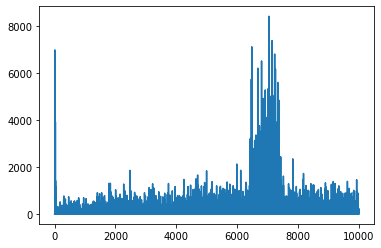

In [15]:
plt.plot(lpath)

আমরা এখানে যা দেখতে পাচ্ছি তা হলো প্রথমে গড় পথের দৈর্ঘ্য বৃদ্ধি পেয়েছে। এটি সম্ভবত এই কারণে হয়েছে যে, যখন আমরা পরিবেশ সম্পর্কে কিছুই জানি না - তখন আমরা খারাপ অবস্থায়, যেমন জল বা নেকড়ের ফাঁদে পড়ার সম্ভাবনা বেশি। যখন আমরা আরও শিখি এবং এই জ্ঞান ব্যবহার করতে শুরু করি, তখন আমরা পরিবেশটি আরও দীর্ঘ সময় ধরে অন্বেষণ করতে পারি, তবে এখনও আপেল কোথায় রয়েছে তা ভালোভাবে জানি না।

যখন আমরা যথেষ্ট শিখে যাই, তখন এজেন্টের জন্য লক্ষ্য অর্জন করা সহজ হয়ে যায়, এবং পথের দৈর্ঘ্য কমতে শুরু করে। তবে, আমরা এখনও অন্বেষণের জন্য উন্মুক্ত থাকি, তাই আমরা প্রায়ই সেরা পথ থেকে সরে যাই এবং নতুন বিকল্পগুলি অন্বেষণ করি, যা পথটিকে আদর্শের চেয়ে দীর্ঘ করে তোলে।

এই গ্রাফে আমরা আরও যা লক্ষ্য করি, তা হলো এক পর্যায়ে পথের দৈর্ঘ্য হঠাৎ বৃদ্ধি পেয়েছে। এটি প্রক্রিয়ার স্টোকাস্টিক প্রকৃতিকে নির্দেশ করে, এবং এটি দেখায় যে আমরা কোনো এক সময়ে Q-Table এর সহগগুলিকে "বিকৃত" করতে পারি, নতুন মান দিয়ে সেগুলি ওভাররাইট করার মাধ্যমে। এটি আদর্শভাবে শেখার হার কমিয়ে (অর্থাৎ, প্রশিক্ষণের শেষের দিকে আমরা Q-Table এর মানগুলোকে কেবলমাত্র ছোট মান দিয়ে সামঞ্জস্য করি) হ্রাস করা উচিত।

সামগ্রিকভাবে, এটি মনে রাখা গুরুত্বপূর্ণ যে শেখার প্রক্রিয়ার সাফল্য এবং গুণমান উল্লেখযোগ্যভাবে নির্ভর করে বিভিন্ন প্যারামিটারের উপর, যেমন শেখার হার, শেখার হারের ক্ষয় এবং ডিসকাউন্ট ফ্যাক্টর। এগুলোকে প্রায়ই **হাইপারপ্যারামিটার** বলা হয়, যাতে সেগুলোকে **প্যারামিটার** থেকে আলাদা করা যায়, যা আমরা প্রশিক্ষণের সময় অপ্টিমাইজ করি (যেমন Q-Table এর সহগ)। সেরা হাইপারপ্যারামিটার মান খুঁজে বের করার প্রক্রিয়াকে বলা হয় **হাইপারপ্যারামিটার অপ্টিমাইজেশন**, এবং এটি একটি আলাদা আলোচনার যোগ্য।


## অনুশীলন
#### একটি আরও বাস্তবসম্মত পিটার এবং নেকড়ে বিশ্ব

আমাদের পরিস্থিতিতে, পিটার প্রায় ক্লান্ত বা ক্ষুধার্ত না হয়ে এক জায়গা থেকে অন্য জায়গায় যেতে পারত। একটি আরও বাস্তবসম্মত বিশ্বে, তাকে মাঝে মাঝে বসে বিশ্রাম নিতে হবে এবং নিজেকে খাওয়াতে হবে। চলুন আমাদের বিশ্বকে আরও বাস্তবসম্মত করি নিম্নলিখিত নিয়মগুলো প্রয়োগ করে:

1. এক জায়গা থেকে অন্য জায়গায় যাওয়ার সময়, পিটার **শক্তি** হারাবে এবং কিছু **ক্লান্তি** অর্জন করবে।
2. পিটার আপেল খেয়ে আরও শক্তি অর্জন করতে পারে।
3. পিটার গাছের নিচে বা ঘাসের উপর বিশ্রাম নিয়ে ক্লান্তি দূর করতে পারে (অর্থাৎ, বোর্ডের এমন জায়গায় হাঁটা যেখানে গাছ বা ঘাস আছে - সবুজ ক্ষেত্র)।
4. পিটারকে নেকড়েকে খুঁজে বের করে হত্যা করতে হবে।
5. নেকড়েকে হত্যা করার জন্য, পিটারের নির্দিষ্ট মাত্রার শক্তি এবং ক্লান্তি থাকা প্রয়োজন, অন্যথায় সে যুদ্ধে হেরে যাবে।

উপরের নিয়ম অনুযায়ী পুরস্কার ফাংশনটি পরিবর্তন করুন, রিইনফোর্সমেন্ট লার্নিং অ্যালগরিদম চালিয়ে গেমটি জেতার সেরা কৌশল শিখুন এবং র্যান্ডম হাঁটার ফলাফলগুলোর সাথে আপনার অ্যালগরিদমের ফলাফল তুলনা করুন, গেম জেতা এবং হারার সংখ্যার ভিত্তিতে।

> **Note**: এটি কাজ করার জন্য আপনাকে হাইপারপ্যারামিটারগুলো সামঞ্জস্য করতে হতে পারে, বিশেষত epochs-এর সংখ্যা। কারণ গেমের সফলতা (নেকড়ের সাথে যুদ্ধ) একটি বিরল ঘটনা, আপনি অনেক দীর্ঘ প্রশিক্ষণের সময় আশা করতে পারেন।



---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিক অনুবাদ প্রদানের চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। মূল ভাষায় থাকা নথিটিকে প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য, পেশাদার মানব অনুবাদ সুপারিশ করা হয়। এই অনুবাদ ব্যবহারের ফলে কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যা হলে আমরা দায়বদ্ধ থাকব না।
